In [ ]:
#Importing the necessary libraries

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from warnings import simplefilter

simplefilter('ignore')


In [ ]:
#Reading the file

comp_dir = Path('/Users/eva/Desktop/Kaggle/store-sales-time-series-forecasting')

store_sales = pd.read_csv(comp_dir/'train.csv', usecols = ['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
dtype = {
    'store_nbr' : 'category',
    'family' : 'category',
    'sales' : 'float32',
    'onpromotion' : 'uint32'
},
parse_dates = ['date'])

store_sales['date'] = store_sales.date.dt.to_period('D')

store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales =  store_sales.groupby(['family','date']).mean().unstack('family').loc['2017']

test = pd.read_csv(comp_dir/'test.csv',
                   dtype = {'store_nbr': 'category',
                            'family' : 'category',
                            'onpromotion' : 'uint32'},
                    parse_dates = ['date']
)


test['date'] = test.date.dt.to_period('D')

test = test.set_index(['store_nbr', 'family', 'date']).sort_index()



The training set ends on 2017-08-15, which is the forecast origin. The test set comprises dates 2017-08-16 to 2017-08-31, which is the forecast horizon. There is one step between the origin and horizon, so we have the lead time of one day. In other words, we need a 16-step forecast with 1-step lead time. 

In [ ]:
#Function for creating lags
def make_lags(ts, lags, lead_time = 1):
   return pd.concat(
      {f'y_lag{i}' : ts.shift(i) for i in range(lead_time, lags+lead_time)}, axis = 1
   )
   


In [ ]:
#Function for creating steps
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step{i+1}' : ts.shift(-i) for i in range(steps)
         }, axis = 1
    )

**Creating Multistep Dataset for Store Sales**

In [ ]:
y = family_sales.loc[:, 'sales']


## Making 4 lag features

X = make_lags(y, 4).dropna()



##Making 16 steps
y=  make_multistep_target(y, 16).dropna()

#Creating an inner join
y, X = y.align(X, join = 'inner', axis = 0)



In [ ]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y= y.stack('family')  # wide to long

display(y)

**Forecast with the DirRec Strategy**


In [80]:
from sklearn.multioutput import RegressorChain
model = RegressorChain(base_estimator= XGBRegressor())
model.fit(X,y)

y_pred = pd.DataFrame(
    model.predict(X),
    index = y.index,
    columns = y.columns
).clip(0.0)

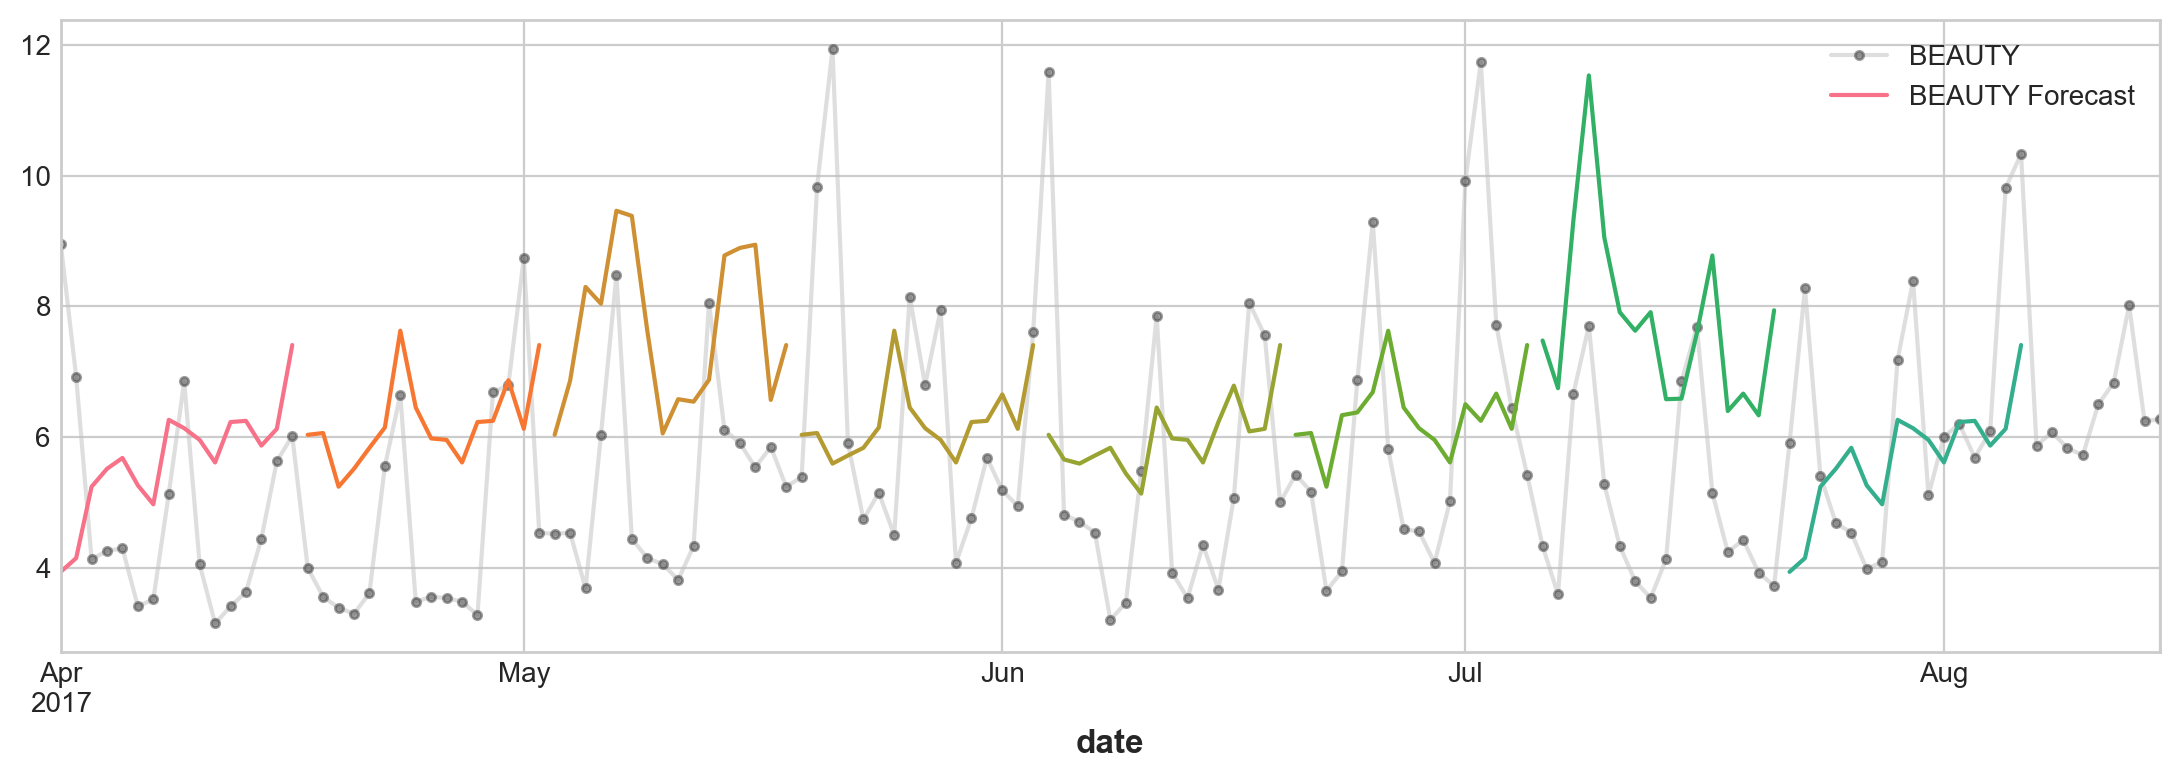

In [81]:

FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])